## Nibe pi LSTM network
Reads data from HA database and trains a LSTM net

### Python's SQLite3 support


This access method is very simple and perfect if you want to have a quick look at your data.

In [89]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pytz
from pytz import timezone
import copy
from math import sqrt
from pysolar.solar import *
import datetime

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import losses

In [90]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
import mlflow.keras

mlflow.keras.autolog()
mlflow.set_tracking_uri('http://192.168.1.4:5000/')
mlflow.set_experiment("nibe")


In [92]:
latitude_deg = 55.6915 # positive in the northern hemisphere
longitude_deg = 13.230412 # negative reckoning west from prime meridian in Greenwich, England
futureSteps = 12
timestep = '15T'
scaler = sk.preprocessing.MinMaxScaler()

Create a connection to the database.

In [93]:
conn = sqlite3.connect('/home/homeassistant/.homeassistant/home-assistant_v2.db')

In [94]:
def getDataFrame(sensor, mean=False):
    df = pd.read_sql_query("SELECT state, last_changed FROM states WHERE entity_id = 'sensor." + sensor + "' AND state != 'unknown'", conn,index_col='last_changed', parse_dates=['last_changed'])
    df['state'] = df['state'].astype(float)
    if mean:
        df = df.resample(timestep).mean()
    else:
        df = df.resample(timestep).last()

    df = df.fillna(method='ffill')
    return df



In [95]:
#Group weathersymbols according to how much sun (yr.no)
def updateWeather(dfWeatherSymbol):
    resArray = []
    sunIcons = [[1],[2],[3,40,5,41,42,7,43,44,8,45,24,6,25,26,20,27,28,21,29],[10,11,12,13,14,15,22,23,30,31,32,33,34,46,47,48,49,50,4,9]]
    for icon in dfWeatherSymbol['state']:
        res = -1
        for i in range(4):
            if icon in sunIcons[i]:
                resArray.append(4-i)

    dfWeatherSymbol['state'] = resArray
    return dfWeatherSymbol

In [96]:
def getInitialDataFrame():
    dfIndoor = getDataFrame('downstairs_temperature')
    dfOutdoor = getDataFrame('outdoor_temperature')
    dfWeatherSymbol = updateWeather(getDataFrame('current_weather_symbol'))
    dfPercipitation = getDataFrame('current_weather_precipitation')
    dfWind = getDataFrame('current_weather_wind_speed')
    dfCalculatedSupply = getDataFrame('nibe_offset_temperature')
    dfSupply = getDataFrame('nibe_supply_temperature', mean=True)
    dfReturn = getDataFrame('nibe_return_temperature', mean=True)
    dfDT = dfSupply['state'] - dfReturn['state']

    df = pd.DataFrame({'Indoor':dfIndoor['state'],
            'IndoorDT':dfIndoor['state'].diff(),
            'Outdoor':dfOutdoor['state'],
            'Weather':dfWeatherSymbol['state'],
#            'Rain':dfPercipitation['state'],
#            'Wind':dfWind['state'],
#            'CalculatedSupplyTemp':dfCalculatedSupply['state'],
            'SupplyTemp':dfSupply['state'],
            'dT':dfDT
           })
    
    df = appendSolarFeature(df)
#    df = appendPrevious(df, 'Indoor',12)
#    df = appendPrevious(df, 'IndoorDT',12)
#    df = appendPrevious(df, 'Outdoor',8)
#    df = appendPrevious(df, 'Weather',8)
#    df = appendPrevious(df, 'dT',8 )
    df = appendWeatherForcast(df)
    df = appendPrevious(df, 'SupplyTemp',8)
    df = appendFuture(df, 'SupplyTemp', 8)
    df = df.reindex(sorted(df.columns), axis=1)

    #Indoor temp must be last, used for training
    df = appendFuture(df, 'Indoor')

    df = df.fillna(method='ffill')
    return df


In [97]:
#Get sun radiation
def appendSolarFeature(df):
    sunRadiationList = list()
    altitudeList = list()
    timeList = list()

    for date in df.index:
        localDate = pytz.utc.localize(date)
        altitude_deg = get_altitude(latitude_deg, longitude_deg, localDate)
        sunRadiationList.append(radiation.get_radiation_direct(date, altitude_deg))

        if altitude_deg < 0:
            altitude_deg = 0
        altitudeList.append(altitude_deg)
        
        seconds  = (localDate - localDate.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
        timeList.append(seconds)

    df['SunRadiation'] = sunRadiationList
    #df['SunAltitude'] =  altitudeList
    df['time'] = timeList
    return df

In [98]:
def appendWeatherForcast(df):
    dfTempForcastT1 = getDataFrame('weather_1_temperature')
    dfTempForcastT2 = getDataFrame('weather_2_temperature')
    dfTempForcastT3 = getDataFrame('weather_3_temperature')

    dfSymbolForcastT1 = updateWeather(getDataFrame('weather_1_symbol'))
    dfSymbolForcastT2 = updateWeather(getDataFrame('weather_2_symbol'))
    dfSymbolForcastT3 = updateWeather(getDataFrame('weather_3_symbol'))
    
    dfWindForecastT1 = getDataFrame('weather_1_wind_speed')
    dfWindForecastT2 = getDataFrame('weather_2_wind_speed')
        
    dataForecast = pd.DataFrame({
        'TempForcast1':dfTempForcastT1['state'],
        'TempForcast2':dfTempForcastT2['state'],
#        'TempForcast3':dfTempForcastT3['state'],
        'WeatherForcast1':dfSymbolForcastT1['state'],
        'WeatherForcast2':dfSymbolForcastT2['state'],
#        'WeatherForcast3':dfSymbolForcastT3['state']
        'WindForcast1':dfWindForecastT1['state'],
#        'WindForcast2':dfWindForecastT2['state']
    })

    df = pd.concat([dataForecast, df], axis=1)
    df = df.fillna(method='ffill')
    return df

In [99]:
def appendPrevious(df, column, steps = 2):
    for i in range(1, steps + 1):
        df[column + 'T-' + str(i)] = df[column].shift(i)
    return df

In [100]:
def appendFuture(df, column, steps = futureSteps):
    for i in range(1, steps + 1):
        df[column + 'T+' + str(i)] = df[column].shift(-i)
    return df

In [101]:
#Use to find features to remove
def findFeaturesToRemove(df):
    current = train(df, hidden=55, nepochs=135)
    print(current)
    while True:
        dropcol = ""
        newdf = copy.deepcopy(df)
        for col in newdf.columns[:-futureSteps]:
            testdf = copy.deepcopy(newdf)
            testdf.drop(columns=col)
            result = train(testdf, hidden=55, nepochs=135)
            print(col + " " + str(result))

            if result < current:
                current = result
                dropcol = col
                print("HIT!")

        print("---------------------\n" + str(current) + " " + dropcol)

        if dropcol == "":
            return newdf
        else:
            newdf.drop(columns=dropcol)

In [102]:
def normalizeDF(df):
    newdf = copy.deepcopy(df)
    x = newdf.values
    x_scaled = scaler.fit_transform(x)
    newdf.values[:,:] = x_scaled
    return newdf

In [103]:
def splitData(df):
    # split into train and test sets
    values = df.values
    n_train_hours = int(len(values)*0.75)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_x, train_y = train[:, :-futureSteps], train[:, -futureSteps:]
    test_x, test_y = test[:, :-futureSteps], test[:, -futureSteps:]

    return train_x, train_y, test_x, test_y

In [104]:
def makePrediction(model, test_x):
    yhat = model.predict(test_x)

    # invert scaling for forecast
    test_x_2 = removeTimeStepDim([test_x])[0]
    inv_yhat = np.concatenate((test_x_2, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    
    return inv_yhat

In [105]:
def addTimestepDim(listOfVectors):
    result = list()
    for vector in listOfVectors:
        result.append(vector.reshape(vector.shape[0],1,vector.shape[1]))
        
    return result

In [106]:
def removeTimeStepDim(listOfVectors):
    result = list()
    for vector in listOfVectors:
        result.append(vector.reshape(vector.shape[0],vector.shape[2]))

    return result

In [107]:
def train(train_x, train_y, test_x, test_y, plot = False, hidden = 32, nepochs = 100, lr=0.0006):
    
    # design network
    model = Sequential()
    model.add(LSTM(hidden, input_shape=(train_x.shape[1], train_x.shape[2])))
#    model.add(LeakyReLU(alpha=0.5))
#    model.add(Dropout(0.05))
    model.add(Dense(futureSteps))

    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    # fit network
    es = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
    history = model.fit(train_x, train_y, epochs=nepochs, batch_size=32, validation_data=(test_x, test_y), verbose=0, shuffle=False, callbacks=[es])
    
    return model, history


RMSE: 0.32387515491800656
Mean absolute error: 0.2549779330209522


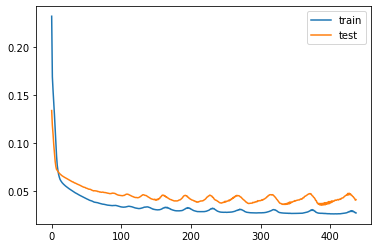

Text(0.5, 0, 'Hours since start')

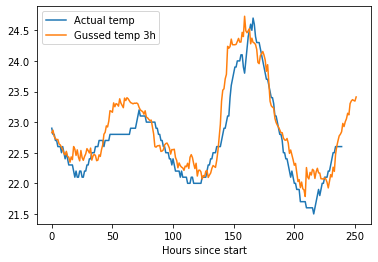

In [113]:
df = getInitialDataFrame()
df = df.dropna()

#Split data
train_x, train_y, test_x, test_y = splitData(normalizeDF(df))
train_x, test_x = addTimestepDim([train_x, test_x])

#df = findFeaturesToRemove(df)

model, history = train(train_x, train_y, test_x, test_y, plot=True, hidden=512, nepochs=1000, lr=0.0002)

inv_yhat = makePrediction(model,test_x)
inv_y = df.values[-inv_yhat.shape[0]:,-futureSteps:]

rmse = sqrt(mean_squared_error(inv_y[:-futureSteps,-1], inv_yhat[:-futureSteps,-1]))
mae = mean_absolute_error(inv_y[:-futureSteps,-1], inv_yhat[:-futureSteps,-1])

print("RMSE: " + str(rmse))
print("Mean absolute error: " + str(mae))

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.plot(inv_y[:-futureSteps,-1], label='Actual temp')
plt.plot(inv_yhat[:,-1], label='Gussed temp 3h')
plt.legend()
plt.xlabel('Hours since start')


In [109]:

#dfDiff = abs(df['Indoor'].diff(3)).dropna()
#print('Average temp diff for 3 timesteps: \n' + str(dfDiff.mean()))

rmse = sqrt(mean_squared_error(np.ones(df['Indoor'].shape[0])*df['Indoor'].mean(), df['Indoor']))
print('\nRMSE from mean: \n' + str(rmse))

print("\nMean absolute error:\n" + str(mean_absolute_error(np.ones(df['Indoor'].shape[0])*df['Indoor'].mean(), df['Indoor'])))


RMSE from mean: 
0.8932342575857573

Mean absolute error:
0.6882186084502856


[22.69612142 22.72138236 22.8270771  22.85980098 22.96430849 23.05553706
 23.11352335 23.18725664 23.24566525 23.30055654 23.34156931 23.41551026]
[22.69704039 22.72364972 22.82701285 22.85875817 22.96228902 23.05084318
 23.10867365 23.17952398 23.24060891 23.29754012 23.34426987 23.41527967]
[22.69796076 22.72591153 22.82700321 22.8577948  22.96036797 23.04627707
 23.10395683 23.17194963 23.23566721 23.29465907 23.34708243 23.41513101]
[22.69888214 22.72816873 22.82704746 22.85691161 22.95854375 23.04183654
 23.09937203 23.16453123 23.23083795 23.29191105 23.35000394 23.41506355]
[22.69980484 22.73042098 22.82714501 22.85610741 22.95681562 23.03751927
 23.09491661 23.15726939 23.22612026 23.28929402 23.3530335  23.4150745 ]
[22.70072885 22.73266855 22.82729557 22.85538193 22.9551824  23.03332481
 23.09058868 23.15016072 23.22151239 23.28680506 23.3561707  23.41516226]
[22.70165411 22.73491144 22.82749782 22.85473399 22.95364294 23.0292501
 23.08638619 23.14320452 23.21701331 23.284442

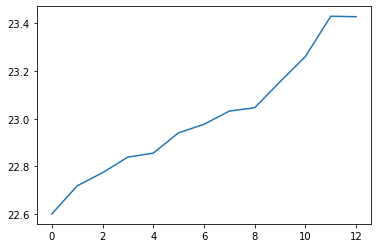

In [110]:
updatedDf = getInitialDataFrame()

goal = 22.5
best = 100
result = 0
vectorRes = []

#lastRow = df.iloc[:]

for i in range(25,50,1):
    updatedDf['SupplyTemp'][-1:] = i
    updatedDf['SupplyTempT+1'][-1:] = i
    updatedDf['SupplyTempT+2'][-1:] = i

    updatedDf['SupplyTempT+1'][-2:] = i
    updatedDf['SupplyTempT+2'][-2:] = i

    updatedDf['SupplyTempT+2'][-2:] = i

    current_x = normalizeDF(updatedDf).values[-1:, :-futureSteps]

    inv_yhat = makePrediction(model, addTimestepDim([current_x])[0])
    print(inv_yhat[-1,-futureSteps:])

    rest = sum(abs(inv_yhat[-1,-futureSteps:] - goal))
    if rest < best:
        result = i
        best = rest
        vectorRes = inv_yhat[-1,-futureSteps:]

plotX = np.insert(vectorRes, 0, df['Indoor'][-1]) 


print(result)
plt.plot(plotX)        
    